[*********************100%***********************]  1 of 1 completed


Sharpe Ratio: 0.88
Max Drawdown: 28.76%


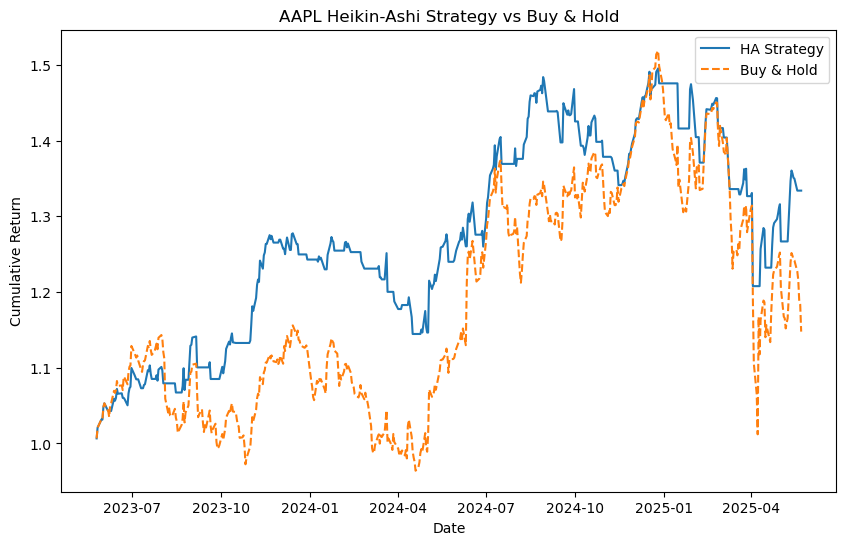

In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 配置
ticker    = "AAPL"
period    = "2y"
interval  = "1d"

# 2. 拉取数据
df = yf.download(ticker, period=period, interval=interval).dropna()

# 3. 计算 Heikin-Ashi K 线
df['HA_Close'] = (df[['Open','High','Low','Close']].sum(axis=1)) / 4
# 先计算第一根 HA_Open
first_ha_open = (df['Open'].iloc[0] + df['Close'].iloc[0]) / 2

# 用一个单独的 Series 迭代填充 HA_Open
ha_open = pd.Series(index=df.index, dtype=float)
ha_open.iloc[0] = first_ha_open
for i in range(1, len(df)):
    ha_open.iloc[i] = (ha_open.iloc[i-1] + df['HA_Close'].iloc[i-1]) / 2

df['HA_Open'] = ha_open  # 赋回 DataFrame
df['HA_High'] = df[['High','HA_Open','HA_Close']].max(axis=1)
df['HA_Low']  = df[['Low', 'HA_Open','HA_Close']].min(axis=1)

# 4. 生成简单信号：阳线做多，阴线空仓
df['Position'] = np.where(df['HA_Close'] > df['HA_Open'], 1, 0)

# 5. 回测
df['Return'] = (df['Close'].pct_change()).squeeze() * df['Position'].shift()
cumulative_return = (1 + df['Return']).cumprod()
max_drawdown = (cumulative_return.cummax() - cumulative_return).max()
sharpe_ratio = df['Return'].mean() / df['Return'].std() * np.sqrt(252)

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")

# 6. 可视化对比
plt.figure(figsize=(10,6))
plt.plot(cumulative_return, label='HA Strategy')
# 买入并持有基准
buy_hold = (1 + df['Close'].pct_change()).cumprod()
plt.plot(buy_hold, '--', label='Buy & Hold')
plt.title(f"{ticker} Heikin-Ashi Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()
